### Import Modules

<br>

In [3]:
import requests
import json
import time
import itertools
import wget
import os
import pickle
import numpy as np

import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import precision_recall_curve
import scipy

sns.set_style('white')
import tensorflow as tf
import pandas as pd
import keras
from keras.applications.vgg16 import VGG16
from keras.callbacks import LearningRateScheduler
from keras import callbacks
from keras import regularizers as reg
from keras.optimizers import SGD, Adam
from keras.models import Sequential , Model
from keras.layers import Dense, Dropout, Flatten, Input, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import keras.initializers as init
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import load_model



<br>
### Open the Preprocessed Poster Data

<br>
Features data upload from file and selection of features

<br>

In [4]:
# Open File
x_train_raw = pd.read_csv('Features_All.csv')

# Display available features
for i in range (len(x_train_raw.columns)):
    
    print str(x_train_raw.columns[i])

Unnamed: 0
mR
mG
mB
stdR
stdG
stdB
varR
varG
varB
Dc1
Dc2
Dc3
De1
De2
De3
ID


In [5]:
# Select features
# x_data = x_train_raw.loc[: , ['mR' , 'mG' , 'mB' , 'stdR' , 'stdG' , 'stdB' , 'Dc1' , 'Dc2' , 'Dc3']].values
x_data = x_train_raw.loc[: , ['mR' , 'mG' , 'mB' , 'stdR' , 'stdG' , 'stdB' , 'Dc1' , 'Dc2' , 'Dc3']].values



<br>
### Specify the training/test split

<br>
 - The data will be split into training and test for validation purpose
 - Data augmentation will be subsequently applied for both training and test
 
 <br>

In [6]:
# Specify the split index
train_split = 8000

# Apply the test / train split
x_train = x_data[:train_split,:]
x_test  = x_data[train_split:,:]

print x_train.shape

(8000, 9)




<br>
### Prepare Data for input

<br>
 - Determine the data axis order according tothe keras configuration
 - Define the input and its attributes
 - Center input data and ensure its type as float 
 - Pre-process labels
 
 <br>
 
** 1 - Arrange Data for Input:**

<br>

In [7]:
# Dfine the data number of columns
dat_cols = x_train.shape[1]

# input_shape = (,dat_cols)

# Define Model Input
model_input = Input(shape = (dat_cols,))


<br>
** 2 - Pre-process Data: **

<br>

In [8]:
# Transform to float
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

# Center the data
x_train -= x_train.mean(0)
x_test  -= x_test.mean(0)

# Scale the data
x_train /= x_train.std(0)
x_test  /= x_test.std(0)

# Display train Data attributes
print 'x_train shape:', x_train.shape
print  x_train.shape[0], 'train samples'

# Display test data attributes
print 'x_test shape:', x_test.shape
print  x_test.shape[0], 'test samples'

x_train shape: (8000, 9)
8000 train samples
x_test shape: (1988, 9)
1988 test samples



<br>
** 3 - Output Data Pre-processing : **

<br>

In [9]:
# Extract Labels from File
y_raw = pd.read_csv('Genres_labels_All_cleaned.csv')

# Split into train and test
y_train = y_raw.iloc[:, 1:-1].values[:train_split, :]
y_test  = y_raw.iloc[:, 1:-1].values[train_split:, :]

# Define the number of classes
num_classes = y_train.shape[1]

print 'number of classes:  ' , num_classes

number of classes:   14



<br>
### Model Construction

<br>
 - Initiate Data Augmentation
 - Specify any layer regularization parameters
 - Stack the model architecture
 
<br>
** 1 - Initiate regulariztion: **

<br>

In [10]:
# Specify regularization parameter
reg_par = 0.01


<br>
** 2 - Stack Model:**

<br>

In [11]:
# ---------- Input  ----------------
x = model_input

# ------------ Fully Connected ----------
x = Dense(32 , activation = 'relu' , kernel_initializer = init.he_normal(109),
          kernel_regularizer = reg.l2(reg_par))(x)

#  ----------- Dropout ---------
x = Dropout(0.3)(x)

# ------------- Fully Connected --------
x = Dense(64, activation = 'relu' , kernel_initializer = init.he_normal(109),
          kernel_regularizer = reg.l2(reg_par))(x)

# ------------ Dropout --------------
x = Dropout(0.3)(x)

# ------------- Fully Connected --------
x = Dense(32 , activation = 'relu' , kernel_initializer = init.he_normal(109),
          kernel_regularizer = reg.l2(reg_par))(x)

# ------------ Dropout -----------------
x = Dropout(0.3)(x)
mod_out = Dense(num_classes , activation = 'sigmoid')(x)

# --------- Model Packing ----------
model = Model(inputs = model_input , outputs = mod_out)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
__________


<br>
### Model Compilation and Intiation

<br>
** 1 - Model Compilation: **

<br>

In [12]:
# Specifying Optimization Method
sgd = SGD(lr=1e-5 , momentum = 0.99)

# Model Comilation
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])


<br>
** 3 - Training Parameters: **

<br>

In [13]:
# Batch Size
batch_size = 16

# epochs
epochs = 20


<br>
** 4 - Callback Function: **

<br>

In [14]:
def step_decay(epoch):
    
    lrate = 0.001
    
    if epoch > 20 and epoch <= 40:
        
        lrate = 0.0001
        
    elif epoch > 40:
        
        lrate  =  1e-5
        
    else:
        
        lrate = lrate
        
    return lrate

lr = LearningRateScheduler(step_decay)
callbacks_list = [lr]


<br>
### Training Execution

<br>

In [ ]:

history = model.fit(x_train, y_train, 
                    batch_size=batch_size,             
                    epochs=epochs,
                    verbose = 1,
                    validation_data = (x_test, y_test),
                    callbacks = callbacks_list)

Train on 8000 samples, validate on 1988 samples
Epoch 1/20
8000/8000 [==============================] - 17s - loss: 1.5876 - acc: 0.8039 - val_loss: 0.7136 - val_acc: 0.8440

<br>
** Plot Accurracy**

<br>

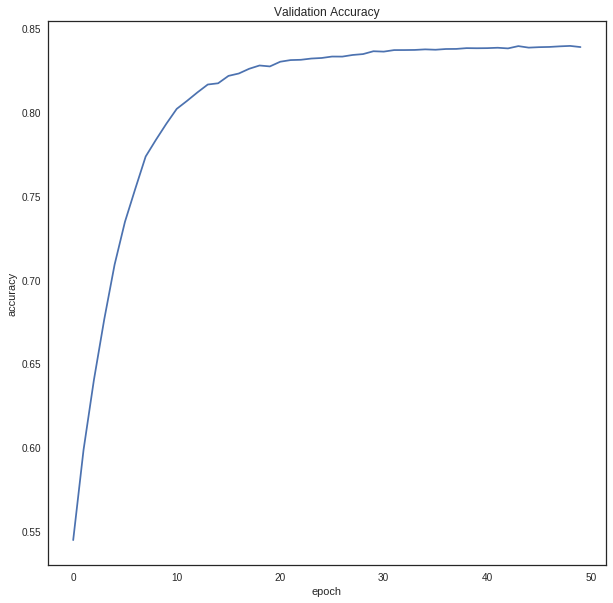

In [59]:
fig = plt.figure (figsize = (10,10))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(history.history['acc'])
ax1.set_xlabel("epoch")
ax1.set_title('Validation Accuracy')
ax1.set_ylabel("accuracy")
plt.show()


<br>
### Export Results to File:

<br>
** 1 - Export Weights : **

<br>

In [20]:
import h5py as h5py

model.save('vgg16.h5')


<br>
** 2 - Export Accurracy **

<br>

In [ ]:
# Conctruct Accurrracy Data Frame
Acc_vgg16 = pd.DataFrame(history.history['acc'] , columns = ['Accuracy'])

# Write to File
Acc_vgg16.to_csv('vgg16_acc.csv')